# Exploring the Bitcoin database


## Analyzing the transactions dataset
The first step after acquiring the dataset from the Bitcoin DB was to properly reduce it's size and transform it to a nice dataset (as a numpy data array). This was achieved by dumping the .dat files produced by the modified Bitcoin client (see https://github.com/dkondor/bitcoin/tree/0.16 for more info) to a database engine, and then querying it to extract the reduced data array.

Query used to create the transaction dataset:
```sql
select
  tx.txID as id,
  bh.block_timestamp as timestamp,
  addresses.address as src_addr,
  tx.n_inputs,
  tx.n_outputs,
  sum(txin.sum) as inputs_sum,
  sum(txout.sum) as outputs_sum,
  min(txin.sum) as min_input,
  max(txin.sum) as max_input,
  min(txout.sum) as min_ouput,
  max(txout.sum) as max_output
from
  tx
  join bh on tx.blockID = bh.blockID
  join txin on tx.txID = txin.txID
  join txout on tx.txID = txout.txID
  join addresses on txin.addrID = addresses.addrID
group BY
  tx.txID
```

In [1]:
# Helper functions to load the data and prepare it in some way

import numpy as np
import os

BH_FILE = "bh.dat"
TX_FILE = "tx.dat"
TXIN_FILE = "txin.dat"
TXOUT_FILE = "txout.dat"

LINE_BATCH_SIZE = 500


def load_dat(path, as_ndarray=False, cast_to=None, start=0, n_lines="all"):
    """
     Read 'n_lines' lines starting from line 'start' from the file 'path'.
     Return numpy array or list of tuples.
    """
    result_list = []
    with open(path, "r") as fh:
        for i, line in enumerate(fh):
            if i >= start and (n_lines == "all" or n_lines > 0):
                split_line = line.split()
                cast_line = map(cast_to, split_line) if cast_to is not None else split_line
                result_list.append(tuple(cast_line))
                if type(n_lines) is not str:
                    n_lines -= 1
    return np.array(result_list) if as_ndarray else result_list


def prepare_subblockchain(data_folder, new_data_folder, start_block, n_blocks):
    """
     Given data in the directory 'data_folder' extract from it a subset of 'n_blocks' blocks
     (and TXs associated with these blocks) starting with block 'start_block.
     Save the new blockchain in the directory 'new_data_folder' with the same structure
     as in 'data_folder'. Basically a vertical reduction of the blockchain.
     For now in only handles the files: BH, TX, TXIN, TXOUT.
    """
    print(f"Trimming {BH_FILE}... ")
    _handle_single_file(
        data_folder, new_data_folder, BH_FILE, start_block, n_blocks, LINE_BATCH_SIZE
    )

    print(f"Trimming {TX_FILE}... ")
    filter_func_tx = (
        lambda line: int(line[1]) >= start_block
        and int(line[1]) <= start_block + n_blocks
    )
    _handle_single_file(
        data_folder,
        new_data_folder,
        TX_FILE,
        start_block,
        n_blocks,
        LINE_BATCH_SIZE,
        filter_func=filter_func_tx,
    )

    filtered_txs = load_dat(
        path=os.path.join(new_data_folder, TX_FILE), start=0, n_lines="all"
    )
    filtered_txs_ids = [t[0] for t in filtered_txs]
    filter_func_tx_full = lambda line: line[0] in filtered_txs_ids

    print(f"Trimming {TXOUT_FILE}... ")
    _handle_single_file(
        data_folder,
        new_data_folder,
        TXOUT_FILE,
        start_block,
        n_blocks,
        LINE_BATCH_SIZE,
        filter_func=filter_func_tx_full,
    )

    print(f"Trimming {TXIN_FILE}... ")
    _handle_single_file(
        data_folder,
        new_data_folder,
        TXIN_FILE,
        start_block,
        n_blocks,
        LINE_BATCH_SIZE,
        filter_func=filter_func_tx_full,
    )
    print("Done.")


def _handle_single_file(
    old_dir,
    new_dir,
    file_name,
    start_block,
    n_blocks,
    batch_size,
    filter_func=lambda x: True,
):
    n_chunks = n_blocks // batch_size
    for j in range(n_chunks):
        _read_and_append_to_new(
            old_dir,
            new_dir,
            file_name,
            start_block + j * batch_size,
            batch_size,
            filter_func,
        )
    leftover = n_blocks % batch_size
    _read_and_append_to_new(
        old_dir, new_dir, file_name, start_block + n_chunks * batch_size, leftover, filter_func
    )


def _read_and_append_to_new(old_dir, new_dir, file_name, start, n_lines, filter_func):
    content = load_dat(os.path.join(old_dir, file_name), start=start, n_lines=n_lines)
    with open(os.path.join(new_dir, file_name), "a+") as fh:
        for line in content:
            if filter_func(line):
                fh.write(" ".join(list(line)) + "\n")


In [2]:
# Loading the transactions data

TX_DATASET_PATH = "../btc_data/transactions.txt"

tx_dataset = load_dat(TX_DATASET_PATH, as_ndarray=True, start=2, cast_to=np.float32)
print(f"Transaction dataset shape: {tx_dataset.shape}")
print(f"Memory used by the transactions dataset: {tx_dataset.nbytes} bytes")
print(f"Data type of the transactions dataset: {tx_dataset.dtype}")

tx_dataset_cols = load_dat(TX_DATASET_PATH, n_lines=1)[0]
print("Column names of the transactions dataset:\n", tx_dataset_cols)

Transaction dataset shape: (1642765, 11)
Memory used by the transactions dataset: 72281660 bytes
Data type of the transactions dataset: float32
Column names of the transactions dataset:
 ('id', 'timestamp', 'src_addr', 'n_inputs', 'n_outputs', 'inputs_sum', 'outputs_sum', 'min_input', 'max_input', 'min_ouput', 'max_output')


## Description of the transactions dataset:
The dataset contains 1 642 765 last transaction created on the Bitcoin network as of Feb 2018. The columns present in the dataset are as follows:
* **id** - the ID of a given transaction
* **timestamp** - Unix timestamp of when the transaction has been issued (closly tied to the time of creation of a the block in which this transaction has been added)
* **src_addr** - represents the address (based on the public key) of the user who created this transaction
* **n_inputs** - number of input transactions attached to this transaction
* **n_outputs** - number of output transactions defined by this transaction
* **inputs_sum** - the total sum of currency value for the input transactions to this transaction
* **outputs_sum** - the total sum of currency value for the output transaction o this transaction
* **min_input** - the miniaml currency value of an input to this transaction
* **max_input** - the maximal currency value of an input to this transaction
* **min_output** - the minimal currencly value of an output defined by this transaction
* **max_output** - the maximal currency value of an output defined by this transaction

*All currency values are to be interpreted as multiplies of Satoshis (1e-8 BTC)*

In [3]:
# An important step of the analysis was to make sure that the data is in the proper
# type, that there are no Null values and the the data is semantically correct
# We also want to make sure that some columns (like n_inputs or n_outputs) are not negative.


def ensure_cols_non_negative(dataset, cols):
    for index in cols:
        dataset_slice = dataset[:, index]
        negatives = dataset_slice[dataset_slice < 0]
        if len(negatives) > 0:
            raise ValueError(f"Column {index} contained a negative value!")


def ensure_cols_not_nan(dataset, cols):
    for index in cols:
        dataset_slice = dataset[:, index]
        nans = dataset_slice[dataset_slice == np.NaN]
        if len(nans) > 0:
            raise ValueError(f"Column {index} contained a NaN value!")


ensure_cols_non_negative(tx_dataset, [1, 3, 4, 5, 6, 7, 8, 9, 10])
ensure_cols_not_nan(tx_dataset, range(11))

Mając pewność, że dane są w odpowiednim formacie oraz brak w nich niedopuszczalnych wartości możemy przejść do faktycznej części związanej z eksploracją. W pierwszym kroku policzone zostaną podstawowe statystyki zebranego zbioru danych (**średnie, odchylenia standardowe**, etc).

In [4]:
import pandas as pd

tx_dataframe = pd.DataFrame(data=tx_dataset, columns=tx_dataset_cols)
tx_dataframe.describe()

/home/patryk/.pyenv/versions/3.7.6/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,id,timestamp,src_addr,n_inputs,n_outputs,inputs_sum,outputs_sum,min_input,max_input,min_ouput,max_output
count,1.642765e+06,1.642765e+06,1642765.0,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06
mean,2.975028e+08,1.517750e+09,337005920.0,3.828510e+00,2.809052e+00,1.251236e+09,1.084558e+09,2.107748e+08,2.501226e+08,3.168299e+07,2.521970e+08
std,4.746007e+05,1.927843e+05,70769608.0,2.225318e+01,1.844658e+01,6.212978e+09,5.959210e+09,8.275816e+08,8.978593e+08,2.671221e+08,9.023756e+08
min,2.966811e+08,1.517425e+09,76316.0,1.000000e+00,1.000000e+00,3.000000e+02,0.000000e+00,1.000000e+00,3.000000e+02,0.000000e+00,0.000000e+00
25%,2.970921e+08,1.517577e+09,341471360.0,1.000000e+00,2.000000e+00,3.358684e+06,2.334742e+06,6.860410e+05,1.503376e+06,1.210000e+05,1.472375e+06
50%,2.975031e+08,1.517758e+09,368037376.0,1.000000e+00,2.000000e+00,2.691864e+07,1.915268e+07,5.522000e+06,1.132616e+07,9.443740e+05,1.105079e+07
75%,2.979141e+08,1.517921e+09,369075712.0,1.000000e+00,2.000000e+00,1.934057e+08,1.282015e+08,5.768067e+07,8.312874e+07,4.605574e+06,8.203275e+07
max,2.983251e+08,1.518087e+09,370269472.0,1.099000e+03,3.351000e+03,9.999997e+10,9.999997e+10,9.999999e+09,9.999999e+09,9.999999e+09,9.999999e+09


### Podsumowanie statystyk
Jedną z pierwszych rzeczy, która rzuca się w oczy jest fakt, że niektóre z cech posiadają bardzo dużą wariancję. Cech te są powiązane z ilością waluty w obiegu. Przykładowo odchylenie standardowe cechy reprezentujące maksymalną kwotę wyjściową transakcji jest równe ok. 10e8. Wynika to z faktu, iż system walutowy Bitcoina jest dość zfragmentaryzowany - każda transakcja, której suma wejść przekracza sumę wyjść musi w rezultaci de facto tworzyć nową pomocniczą transakcję na swój adres, tak aby reszta z powrotem wróciła na nasze konto. W związku z tym w sieci mogą istnieć transakcje o na prawdę dużych kwotach (liczonych w miliardach satoshi), a jednocześnie istnieć może mnóstwo transakcji o małej wartości wynikających z w/w kwoty zwrotnej.

Ciekawa jest też analiza cechy src_adddr. Co prawda nie reprezentuje ona żadnej faktycznej wartości liczbowej, jednak i tak może dowiedzieć się ciekawych faktów z analizy jej momentów. I tak przykładowo minimalna wartośc tej cechy to 76316, co oznacza, że w przygotowanym przez nas zbiorze wystąpiły transakcję stworzone przez osobę od bardzo niskim indentyfikatorze, co z kolei oznacza, że osoba ta należała do grupy początkowych użytkoników sieci Bitcoin.

Warto również zaznaczyć, że maksymlna wartość pola srd_addr to ponad 370 mln. - możemy to interpretować jako fakt, iż w sieci Bitcoin istnieje obecnie taka właśnie ilość adresów (nie jest to jednak jednoznaczne z liczbą fizycznych użytnikowników, których jest na pewno zdecydowanie mniej z uwagi na fakt, że obecnie zaleca się aby każdą transakcję wykonywać z osobnego adresu publicznego, poza tym fragmentaryzacja majątku na różne adresy jest dobą praktyką jeśli chodzi o bezpieczeństwo).

Jedną z najistotniejszych statystyka w kontekście zrozumienia dynamiki całej sieci jest na pewno średnia ilość wejść do transakcji (i analogicznie - średnia ilość wyjść). W przypadku analizowanego przez nas wycinka czasowego transkacji średnia ilość wejść wyniosła 3.83, zaś średnia ilość wyjść niewiele mniej, bo 2.81. Średnią ilość wyjść można dość łatwo zainterpretować: często transakcja "powołuje" się na tyle wejść, że te nie sumują się dokładnie do jej wartości, wtedy do powstałej reszty tworzone jest nowe wyjść na adres twórcy. Mechaznim ten pozwala sugerować, że średnia ta powinna być nieco mniejsza niż 2.0, gdyż zdarzają się transakcje, których suma wejść jest dokładnie równa sumie wyjść. Jednak należy pamiętać, że w systemie możliwe są również bardziej rozbudowane transakcję wysyłające środki do wielu różnych odbiorców - to właśnie powoduje, że średnia ilość wyjść jest wyraźnie większa niż 2.0. Znacznie cięższa do interpretacji jest wartość średniej ilości wejść. W tym przypadku możemy jedynie postawić hipotezę, że wspomniana wcześniej fragmenryzacja zbioru transakcji faktycznie występuje, ale nie jest aż tak intensywna jak możnaby na początku zakładac.

## Analiza PCA
W następnym kroku przeprowadzone zostanie analiza głównych składowych zbioru transakcji. Posłużymy się w tym celu klasą PCA z biblioteki sklearn.

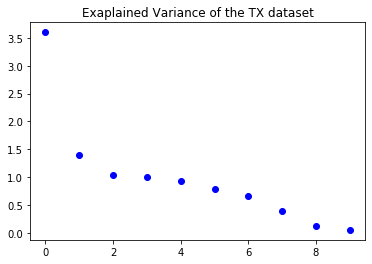

In [19]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib import pyplot as plt

# zalecanym pierwszym krokiem jest odpowiednie przeskalowanie zbioru danych
scaler = preprocessing.StandardScaler()

# Wyrzucamy kolumnę ID
scaled_tx_dataset = scaler.fit_transform(tx_dataset[:, 1:])

# dopiero teraz można przejść do faktycznej analizy PCA

pca = PCA()
transformed_tx_dataset = pca.fit_transform(scaled_tx_dataset)

plt.title("Exaplained Variance of the TX dataset")
plt.plot(pca.explained_variance_, 'bo')
plt.show()

Bezwzględne wartości wariancji mogą być mylące więc pomocne jest również sporządzenie wykresu wartości względnych:

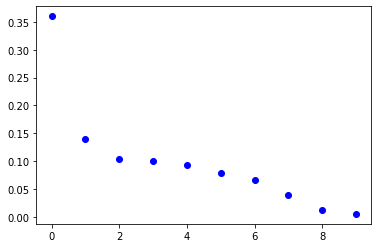

In [20]:
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.show()

Jak widać, pierwsza z cech odpowiada za znaczną część wariancji (czyli przenosi najwięce informacji - oczywiście przy zachowaniu założeń, jakie są wymagane do analizy PCA).

In [21]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
print("Attribute, PC1, PC2")
for i in range(0, pc1.shape[0]):
    print("Coords in feature space:" + repr(pc1[i]) + ":" + repr(pc2[i]))

Attribute, PC1, PC2
Coords in feature space:0.0013492937:0.041651968
Coords in feature space:-0.055295005:-0.39557773
Coords in feature space:0.07199168:0.65465206
Coords in feature space:0.0813536:0.056610502
Coords in feature space:0.39141592:0.04756681
Coords in feature space:0.3118438:0.45753974
Coords in feature space:0.45255437:-0.29096586
Coords in feature space:0.4928985:-0.2006614
Coords in feature space:0.21123642:0.24576336
Coords in feature space:0.49225152:-0.11436187


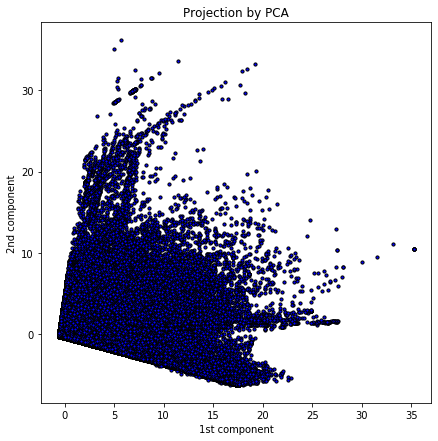

In [22]:
plt.figure(figsize=(7,7))
x = transformed_tx_dataset[:, 0]
y = transformed_tx_dataset[:, 1]
plt.scatter(x, y, c="blue", s=10, edgecolor="k")
plt.title("Projection by PCA")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()

Na wykresie projekcji do 2D widać wyraźnie narożnik wynikający prawdopodobnie z ucięcią całego blockchainu. Poza tym widać, że większość większość sampli skupia się z grubsza w jednym regionie.

In [25]:
# Policzmy średnią, czyli "Per-feature empirical mean, estimated from the training set"

average_tx = pca.mean_
print('Average transaction in feature space: ', average_tx)

Average transaction in feature space:  [ 9.2197952e-06 -9.1200554e-06  7.6392600e-05  2.5347003e-06
  4.4783151e-06  9.0392319e-07  9.9385704e-07  1.3089913e-06
 -4.8005259e-06  8.1952112e-07]


In [28]:
# Możemy również sprawdzić, w jakim stopniu będziemy w stanie odtworzyć dane
reconstructed_ = np.dot(pca.transform(scaled_tx_dataset)[:,:], pca.components_[:,:])
reconstructed_ += pca.mean_

print(scaled_tx_dataset[0, :])
print(reconstructed_[0, :])

[-1.6877625  -3.931551   -0.12710594 -0.04385923  1.6324837   0.7738866
  6.629118    6.066417    0.09084614  5.971089  ]
[-1.6877626  -3.9315536  -0.12710723 -0.04385641  1.6324879   0.77388287
  6.629119    6.0664196   0.09084495  5.97109   ]


Jak widać zachowanie wszystkich głównych składowych pozwala na idealną rekonstrukcję danych wejściowych.

In [33]:
# Rekonstrukcja z 5 głównych składowych jest już nawet całkiem dobra
reconstructed_5 = np.dot(pca.transform(scaled_tx_dataset)[:,:5], pca.components_[:5,:])
reconstructed_5 += pca.mean_

print(scaled_tx_dataset[0, :])
print(reconstructed_5[0, :])

[-1.6877625  -3.931551   -0.12710594 -0.04385923  1.6324837   0.7738866
  6.629118    6.066417    0.09084614  5.971089  ]
[-1.6660788  -3.8893876  -0.8619154  -0.86725247  3.580794    1.1479019
  5.7859483   5.8623657  -0.14831084  5.51529   ]


Warto również zbadać jak zachowają się inne warianty analizy PCA, np. SparsePCA (z dużym naciskiem na to, by wynikowe wektory były rzadkie)

In [35]:
from sklearn import decomposition

# Parametr ten określa nam wagę kary na normę L1, czyli jak bardzo zależy nam na rzadkości wynikowych wektorów
l1_panelty = 15.0
sparse_pca = decomposition.MiniBatchSparsePCA(alpha=l1_panelty, normalize_components=True)
sparse_pca.fit(scaled_tx_dataset)

pc1 = sparse_pca.components_[0]
pc2 = sparse_pca.components_[1]
print("Attribute, Sparse PC1, Sparse PC2")
for i in range(0, pc1.shape[0]):
    print("Sparse coords in feature space:" + repr(pc1[i]) + ":" + repr(pc2[i]))

/home/patryk/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/decomposition/_sparse_pca.py:23: FutureWarning: 'normalize_components' has been deprecated in 0.22 and will be removed in 0.24. Remove the parameter from the  constructor.
  " constructor.", FutureWarning


Attribute, Sparse PC1, Sparse PC2
Sparse coords in feature space:0.0:-0.06120310717613292
Sparse coords in feature space:0.0041906392247465125:-0.42014298370870673
Sparse coords in feature space:0.5904187809654866:0.7788124982229689
Sparse coords in feature space:-0.38496729961505133:-0.2363459410396767
Sparse coords in feature space:9.384925098907832e-05:0.0
Sparse coords in feature space:0.45274195915691373:0.0
Sparse coords in feature space:0.007200988908226036:-0.11462335047810124
Sparse coords in feature space:0.020041997806636448:-0.04112658489604825
Sparse coords in feature space:0.5163020442048267:-0.3772841970500332
Sparse coords in feature space:0.1766115870968526:-0.012347788238143606


Reasumując, postanowiliśmy zachować wszystkie cechy wejściowe, gdyż każda z nich w dość istotny sposób dodaje swój wkład do entropii całego zbioru danych.